# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way conbines unsupervised and supervised method. 

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. The classification model will based on the pretrained model from supervised images and retrained with the categories labelled by the unsupervised methods.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

In [1]:
from mylibs.dataloader import getDataLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 50
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

## Baseline #1, use only first K-class labelled data to train

##### Load the K labelled categories on Fashion-MNIST dataset

In [4]:
%%time
train_data_loader, test_data_loader = getDataLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=6, USE_GPU=USE_GPU)

Wall time: 10.7 s


##### Train the model with the K categories

Epoch: 1 Loss: 0.0086 Accuracy: 0.8032 F1_score: 0.8022
Epoch: 2 Loss: 0.0062 Accuracy: 0.8558 F1_score: 0.8550
Epoch: 3 Loss: 0.0056 Accuracy: 0.8701 F1_score: 0.8695
Epoch: 4 Loss: 0.0052 Accuracy: 0.8805 F1_score: 0.8800
Epoch: 5 Loss: 0.0049 Accuracy: 0.8868 F1_score: 0.8863
Epoch: 6 Loss: 0.0047 Accuracy: 0.8933 F1_score: 0.8929
Epoch: 7 Loss: 0.0044 Accuracy: 0.8978 F1_score: 0.8974
Epoch: 8 Loss: 0.0043 Accuracy: 0.9030 F1_score: 0.9027
Epoch: 9 Loss: 0.0041 Accuracy: 0.9066 F1_score: 0.9062
Epoch: 10 Loss: 0.0040 Accuracy: 0.9101 F1_score: 0.9098
Epoch: 11 Loss: 0.0038 Accuracy: 0.9142 F1_score: 0.9139
Epoch: 12 Loss: 0.0037 Accuracy: 0.9167 F1_score: 0.9165
Epoch: 13 Loss: 0.0036 Accuracy: 0.9196 F1_score: 0.9194
Epoch: 14 Loss: 0.0035 Accuracy: 0.9223 F1_score: 0.9220
Epoch: 15 Loss: 0.0034 Accuracy: 0.9256 F1_score: 0.9254
Epoch: 16 Loss: 0.0033 Accuracy: 0.9283 F1_score: 0.9281
Epoch: 17 Loss: 0.0032 Accuracy: 0.9298 F1_score: 0.9296
Epoch: 18 Loss: 0.0031 Accuracy: 0.9320 

<Figure size 432x288 with 0 Axes>

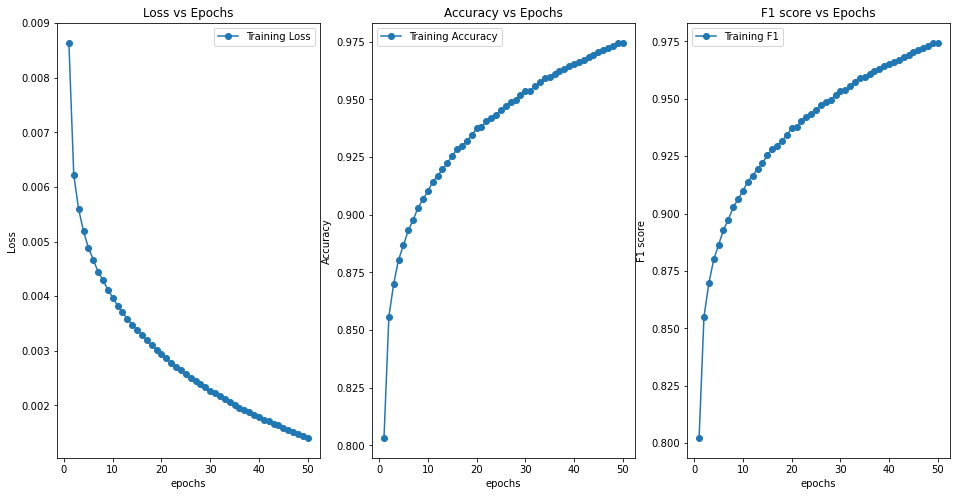

Wall time: 20min 39s


In [5]:
%%time
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
eval_metrics = []

# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, EPOCH+1):
    eval_metric = train(train_data_loader, model, loss_function, optimizer, USE_GPU)
    eval_metrics.append(eval_metric)
    print(f"Epoch: {epoch} Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
report_summary(eval_metrics)

In [ ]:
%%time
ResNet_model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
optimizer = torch.optim.Adadelta(ResNet_model.parameters(), lr=0.01)
eval_metrics = []

# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, EPOCH+1):
    eval_metric = train(train_data_loader, ResNet_model, loss_function, optimizer, USE_GPU)
    eval_metrics.append(eval_metric)
    print(f"Epoch: {epoch} Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
report_summary(eval_metrics)

##### Validating the trained model on the labelled / unlabelled / full test data.

In [6]:
labelled_test_loader, unlabelled_test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=7, USE_GPU=USE_GPU)

In [7]:
%%time
model.eval()
eval_metric = validate(labelled_test_loader, model, loss_function, USE_GPU)
print(f"Result on labelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

eval_metric = validate(unlabelled_test_loader, model, loss_function, USE_GPU)
print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

eval_metric = validate(test_data_loader, model, loss_function, USE_GPU)
print(f"Result on full test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

Result on labelled test set: Loss: 0.0068 Accuracy: 0.8714 F1_score: 0.8714
Result on unlabelled test set: Loss: 0.2130 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set: Loss: 0.0688 Accuracy: 0.6100 F1_score: 0.5256
Wall time: 25.2 s


## Baseline #2, use full Fashion-MNIST dataset to train

##### Load all the data on Fashion-MNIST dataset

In [8]:
%%time
# load entire dataset with label
train_data_loader, test_data_loader = getDataLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=7, USE_GPU=USE_GPU)

Wall time: 11.2 s


##### Train the model with the all categories labelled

Epoch: 1 Loss: 0.0076 Accuracy: 0.8339 F1_score: 0.8326
Epoch: 2 Loss: 0.0053 Accuracy: 0.8824 F1_score: 0.8817
Epoch: 3 Loss: 0.0047 Accuracy: 0.8955 F1_score: 0.8951
Epoch: 4 Loss: 0.0043 Accuracy: 0.9053 F1_score: 0.9050
Epoch: 5 Loss: 0.0040 Accuracy: 0.9112 F1_score: 0.9109
Epoch: 6 Loss: 0.0037 Accuracy: 0.9167 F1_score: 0.9164
Epoch: 7 Loss: 0.0035 Accuracy: 0.9225 F1_score: 0.9222
Epoch: 8 Loss: 0.0033 Accuracy: 0.9272 F1_score: 0.9270
Epoch: 9 Loss: 0.0032 Accuracy: 0.9311 F1_score: 0.9308
Epoch: 10 Loss: 0.0030 Accuracy: 0.9348 F1_score: 0.9346
Epoch: 11 Loss: 0.0029 Accuracy: 0.9380 F1_score: 0.9378
Epoch: 12 Loss: 0.0027 Accuracy: 0.9412 F1_score: 0.9410
Epoch: 13 Loss: 0.0026 Accuracy: 0.9449 F1_score: 0.9447
Epoch: 14 Loss: 0.0025 Accuracy: 0.9466 F1_score: 0.9464
Epoch: 15 Loss: 0.0024 Accuracy: 0.9480 F1_score: 0.9478
Epoch: 16 Loss: 0.0023 Accuracy: 0.9512 F1_score: 0.9511
Epoch: 17 Loss: 0.0022 Accuracy: 0.9534 F1_score: 0.9533
Epoch: 18 Loss: 0.0021 Accuracy: 0.9553 

<Figure size 432x288 with 0 Axes>

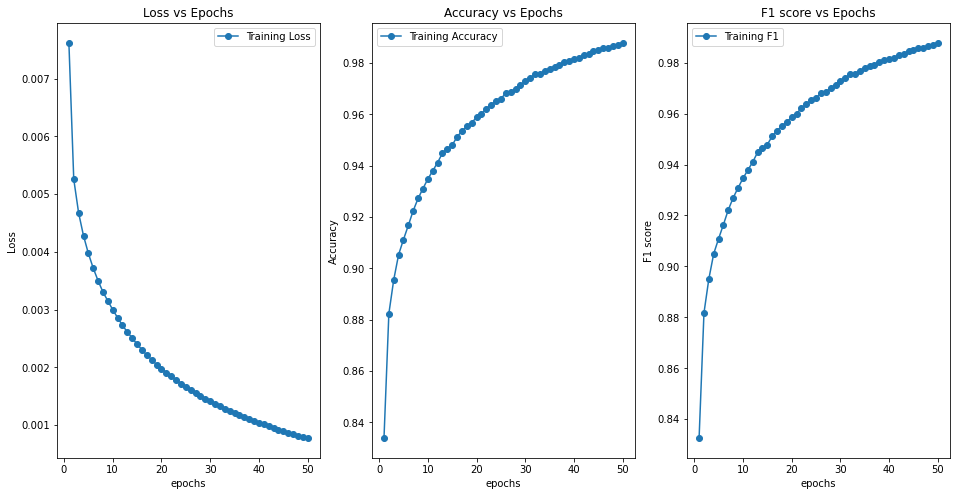

Wall time: 22min 21s


In [9]:
%%time
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
eval_metrics = []

# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, EPOCH+1):
    eval_metric = train(train_data_loader, model, loss_function, optimizer, USE_GPU)
    eval_metrics.append(eval_metric)
    print(f"Epoch: {epoch} Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
report_summary(eval_metrics)

##### Validating the trained model on the labelled / unlabelled / full test data.

In [10]:
labelled_test_loader, unlabelled_test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, mode=7, USE_GPU=USE_GPU)

In [11]:
%%time
model.eval()
eval_metric = validate(labelled_test_loader, model, loss_function, USE_GPU)
print(f"Result on labelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

eval_metric = validate(unlabelled_test_loader, model, loss_function, USE_GPU)
print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

eval_metric = validate(test_data_loader, model, loss_function, USE_GPU)
print(f"Result on full test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

Result on labelled test set: Loss: 0.0074 Accuracy: 0.8691 F1_score: 0.8733
Result on unlabelled test set: Loss: 0.0021 Accuracy: 0.9673 F1_score: 0.9758
Result on full test set: Loss: 0.0059 Accuracy: 0.8986 F1_score: 0.8987
Wall time: 27.7 s


## Label new categories by clastering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Retrain the model with clastering label

## Conclusion